In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import imread
#from detectBlobs import detectBlobs
from drawBlobs import drawBlobs
import numpy as np
#import cv2
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_laplace
from scipy.ndimage.filters import convolve, generic_filter
%matplotlib inline

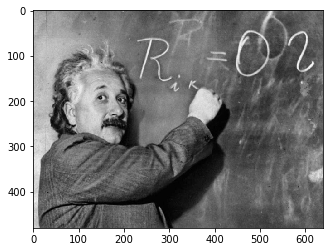

In [3]:
imageName = 'einstein.jpg'
numBlobsToDraw = 500
imName = imageName.split('.')[0]
datadir = os.path.join('..', 'data', 'blobs')
im = imread(os.path.join(datadir, imageName))
plt.imshow(im, cmap='gray')
# BLOBS - n x 5 array with blob in each row in (x, y, radius, angle, score)
#blobs = np.array([im.shape[1]/2, im.shape[0]/2, 100, 1.0])

In [4]:
import sys
def py_im2double(img):
    original_img = img.astype('float')
    img_min, img_max = np.min(im.ravel()), np.max(im.ravel())
    return (original_img - img_min) / (img_max - img_min)

# def fspecial(shape=(3,3),sigma=0.5):
#     """
#     2D gaussian mask - should give the same result as MATLAB's
#     fspecial('gaussian',[shape],[sigma])
#     """
#     m,n = [(ss-1.)/2. for ss in shape]
#     y,x = np.ogrid[-m:m+1,-n:n+1]
#     h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
#     h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
#     sumh = h.sum()
#     if sumh != 0:
#         h /= sumh
#     return h

def fspecial_log(p2, std):
    siz = int((p2-1)/2)
    x = y = np.linspace(-siz, siz, 2*siz+1)
    x, y = np.meshgrid(x, y)
    arg = -(x**2 + y**2) / (2*std**2)
    h = np.exp(arg)
    h[h < sys.float_info.epsilon * h.max()] = 0
    h = h/h.sum() if h.sum() != 0 else h
    h1 = h*(x**2 + y**2 - 2*std**2) / (std**4)
    return h1 - h1.mean()

In [5]:
def laplacian_of_gaussian_filter(sigma):
    kernel_size = np.round(3*sigma)#np.round(6*sigma)
    if kernel_size % 2 == 0:
        kernel_size+=1
    half_size=np.floor(kernel_size/2)
    x, y = np.meshgrid(np.arange(-half_size, half_size+1), np.arange(-half_size, half_size+1))
    
    exp_term=np.exp(-(x**2+y**2) / (2*sigma**2))
    exp_term[exp_term < sys.float_info.epsilon * exp_term.max()] = 0
    if exp_term.sum() != 0:
        exp_term = exp_term/exp_term.sum() 
    else: 
        exp_term
    kernel = -((x**2 + y**2 - (2*sigma**2)) / sigma**2) * exp_term 
    kernel=kernel-kernel.mean()
    return kernel

def create_scale_space(gray_image,sigma_scale_factor,initial_sigma,level):
    h,w=np.shape(gray_image)
    scale_space = np.zeros((h,w,level),np.float32)
    sigma = [0]*(level+1)
    sigma[0] = initial_sigma
    for i in range(0,level):
        print('Convolving with sigma={}'.format(sigma[i]))
        kernel=laplacian_of_gaussian_filter(sigma[i])
        convolved_image=convolve(gray_image,kernel)
        #cv2.imshow("LoG Convolved Image with sigma={}".format(sigma[i]),convolved_image)
        scale_space[:,:,i] = np.square(convolved_image)
        sigma[i+1]=sigma[i]*sigma_scale_factor
    return scale_space,sigma

def create_scale_space2(gray_image,sigma_scale_factor,initial_sigma,level):
    h,w=np.shape(gray_image)
    scale_space = np.zeros((h,w,level),np.float32)
    sigma = [0]*(level+1)
    sigma[0] = initial_sigma
    for i in range(0,level):
        print('Convolving with sigma={}'.format(sigma[i]))
        #kernel=laplacian_of_gaussian_filter(sigma[i])
        #kernel = 
        convolved_image=convolve(gray_image,kernel)
        #cv2.imshow("LoG Convolved Image with sigma={}".format(sigma[i]),convolved_image)
        scale_space[:,:,i] = np.square(convolved_image)
        sigma[i+1]=sigma[i]*sigma_scale_factor
    return scale_space,sigma

In [6]:
processed_im = py_im2double(rgb2gray(im))
initial_sigma = 1.7 #1.6
k = np.sqrt(2) #initial_scale
sigma_scale_factor = np.sqrt(1.7)
n_iterations = 12
level = 14 #10-15
threshold_factor = .003
h, w = processed_im.shape
scale_space = np.zeros((h, w, level))

In [7]:
processed_im = py_im2double(rgb2gray(im))
initial_sigma = 1.4 #1.6
k = np.sqrt(2) #initial_scale
sigma_scale_factor = np.sqrt(1.7)
n_iterations = 15
level = 15 #10-15
threshold = .003
h, w = processed_im.shape
scale_space = np.zeros((h, w, level))
scale_space, sigma = create_scale_space(processed_im,sigma_scale_factor, initial_sigma,level)
max_scale_space = np.copy(scale_space)
mask = [0] * (level)
index = [(1, 0), (-1, 0), (0, 1), (0, -1), 
         (1, 1), (1, -1), (-1, 1), (-1, -1)]
for i in range(0, level):
    mask[i]=int(np.ceil(np.sqrt(2)*sigma[i]))
size = np.shape(scale_space[:,:,0])

def check(l):
    return all(scale_space[i + dx, j + dy, l] < scale_space[i, j, k] 
       for dx, dy in index 
       if  0<= i + dx < size[0] and 0<= j + dy <size[1])

blob_location =[]
for k in range(0,level):
    max_scale_space[:mask[k],:mask[k],k] = 0
    max_scale_space[-mask[k]:,-mask[k]:,k] = 0
    for i in range(mask[k]+1,size[0]-mask[k]-1):
        for j in range(mask[k]+1,size[1]-mask[k]-1):
            if scale_space[i, j, k] < threshold_factor:
                continue
            c_max = check(k)
            l_max = u_max = True
            if k - 1 >= 0:
                l_max = check(k - 1) and \
                scale_space[i, j, k - 1] < scale_space[i, j, k]
            if k + 1 < level:
                u_max = check(k + 1) and \
                scale_space[i, j, k + 1] < scale_space[i, j, k]
            if c_max and l_max and u_max:
                max_scale_space[i, j, k] = 1
                blob_location.append((i, j, k, scale_space[i, j, k]))

blobs = np.zeros((len(blob_location), 5))
i = 0
for center in blob_location:
    x, y = center[0], center[1]
    radius = int(np.ceil(np.sqrt(2)*sigma[center[2]])) 
    score = center[3]
    blobs[i] = [y, x, radius, -1, score] #(x, y, radius, angle, score)
    i+=1

Convolving with sigma=1.4
Convolving with sigma=1.8253766734567416
Convolving with sigma=2.38
Convolving with sigma=3.1031403448764605
Convolving with sigma=4.045999999999999
Convolving with sigma=5.275338586289982
Convolving with sigma=6.878199999999999
Convolving with sigma=8.96807559669297
Convolving with sigma=11.692939999999997
Convolving with sigma=15.245728514378047
Convolving with sigma=19.877997999999995
Convolving with sigma=25.917738474442682
Convolving with sigma=33.792596599999996
Convolving with sigma=44.06015540655257
Convolving with sigma=57.44741422


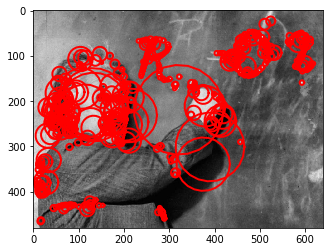

In [31]:
drawBlobs(im, blobs[:, [0, 1, 2, 4]], 500)

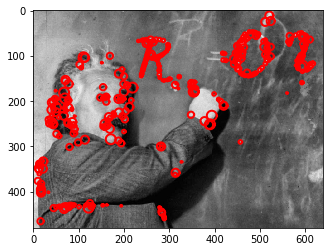

In [29]:
drawBlobs(im, blobs[:, [0, 1, 2, 4]], 500)

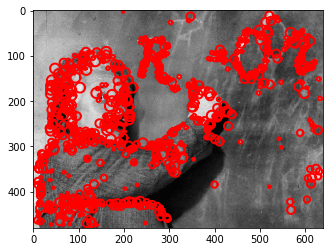

In [26]:
drawBlobs(im, blobs, 250)